In [ ]:
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(10,8)
plt.style.use('ggplot')

In [ ]:
sales_data = pd.read_csv('https://raw.githubusercontent.com/urgedata/pythondata/master/examples/retail_sales.csv')
sales_data.head()

,date,sales
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


In [ ]:
sales_data['date']=pd.to_datetime(sales_data['date'])
sales_data.set_index('date', inplace=True)

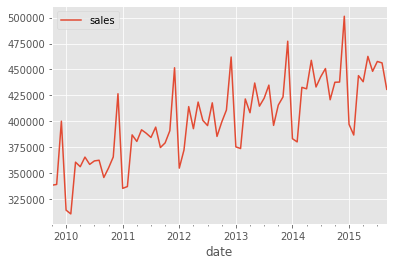

In [ ]:
sales_data.plot()

Let’s check for dependance (aka, correlation) – which is the first assumption for autoregression models.

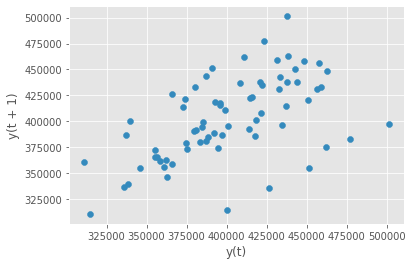

In [ ]:
# Using lag_plot()
pd.plotting.lag_plot(sales_data['sales'])

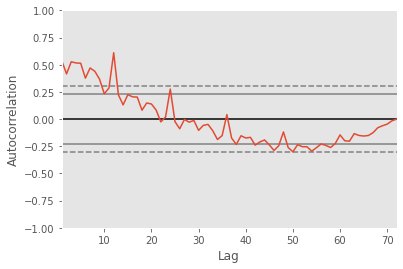

In [ ]:
# Using autocorrelation_plot()
pd.plotting.autocorrelation_plot(sales_data['sales'])

In [ ]:
sales_data['sales'].corr(sales_data['sales'].shift(12))

0.9790985975895788

We used ’12’ above because that looked to be the highest correlation value from the autocorrelation chart. The output of the above command gives us a correlation value of 0.97 which is quite high.



---
Now, let’s take a look at **stationarity**.  I can tell you just from looking at that chart that we have a non-stationary dataset due to the increasing trend from lower left to upper right as well as some **seasonality** (you can see large spikes at roughly the same time within each year).


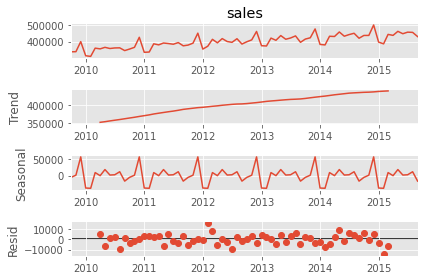

In [ ]:
# Checking for trend, seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(sales_data['sales'], model='additive')
x = decomposed.plot() 

Let’s make it stationary by removing/reducing trend and seasonality.

In [ ]:
sales_data['stationary']=sales_data['sales'].diff()

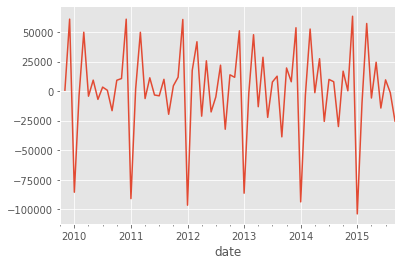

In [ ]:
sales_data['stationary'].plot()

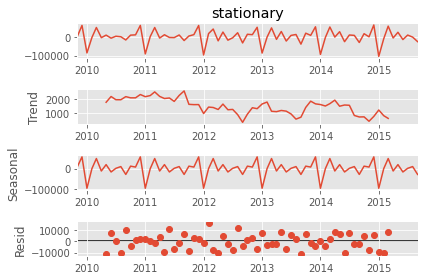

In [ ]:
decomposed_new = seasonal_decompose(sales_data['stationary'].dropna(), model='additive')
x = decomposed_new.plot()

From this new decomposed plot, we can see that there’s still some trend and even some seasonality, which is unfortunate because it means we’d need to take a look at other methods to truly remove trend and seasonality from this particular data series, but for this example, I’m going to play dumb and say that its good enough and keep going.

**Forecasting**

In [ ]:
!pip install statsmodels --upgrade

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

#create train/test datasets
X = sales_data['stationary'].dropna()
train_data = X[1:len(X)-12]
test_data = X[len(X)-12:]

#train the autoregression model
model = AutoReg(train_data, lags=10)
model_fitted = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
print('Coefficients: %s' % model_fitted.params)

Coefficients: const             7720.952626
stationary.L1       -1.297636
stationary.L2       -1.574980
stationary.L3       -1.403045
stationary.L4       -1.123204
stationary.L5       -0.472200
stationary.L6       -0.014586
stationary.L7        0.564099
stationary.L8        0.792080
stationary.L9        0.843242
stationary.L10       0.395546
dtype: float64


In [ ]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:157: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


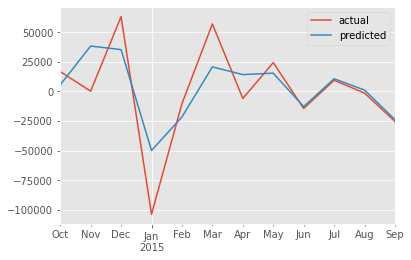

In [ ]:
# create a comparison dataframe
compare_df = pd.concat(
    [sales_data['stationary'].tail(12),
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

#plot the two values
compare_df.plot()

In [ ]:
from sklearn.metrics import r2_score
r2_score(sales_data['stationary'].tail(12), predictions)

0.639272176847809